# Import Ntuple

In [1]:
%load_ext autoreload
%autoreload 2

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util

training_variables = util.training_variables
cs_vars = util.CS_variables
columns = util.all_relevant_variables

In [2]:
# e channel

cut = '(5<B0_roeMbc_my_mask) & (-4<B0_roeDeltae_my_mask) & (B0_roeDeltae_my_mask<1) & (B0_dr<0.1)'

# Load data files
# MC_4S = uproot.concatenate(['../../Samples/MC15ri/e_channel/local_200fb_control/*.root:B0'],
#                           library="np",
#                           cut = cut,
#                           filter_branch=lambda branch: branch.name in columns)

MC_4Soffres = uproot.concatenate(['../../Samples/MC16rd/e_channel/4Soffres_deimos_3/*.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

data_4Soffres = uproot.concatenate(['../../Samples/Data/e_channel/proc16_4Soffres_deimos_3.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

# df_mc_4S = pd.DataFrame(MC_4S)
df_mc_4Soffres = pd.DataFrame(MC_4Soffres)
df_data_4Soffres = pd.DataFrame(data_4Soffres)

In [18]:
# # mu channel

# cut = '(5<B0_roeMbc_my_mask) & (-4<B0_roeDeltae_my_mask) & (B0_roeDeltae_my_mask<1) & (B0_dr<0.1)'

# # Load data files
# MC_4S = uproot.concatenate(['../../Samples/MC15ri/mu_channel/local_200fb_test/*.root:B0'],
#                           library="np",
#                           cut = cut,
#                           filter_branch=lambda branch: branch.name in columns)

# MC_4Soffres = uproot.concatenate(['../../Samples/MC15ri/mu_channel/4Soffres_quaxo_1.root:B0'],
#                           library="np",
#                           cut = cut,
#                           filter_branch=lambda branch: branch.name in columns)

# data_4Soffres = uproot.concatenate(['../../Samples/Data/mu_channel/*4Soffres_quaxo_1.root:B0'],
#                           library="np",
#                           cut = cut,
#                           filter_branch=lambda branch: branch.name in columns)

# df_mc_4S = pd.DataFrame(MC_4S)
# df_mc_4Soffres = pd.DataFrame(MC_4Soffres)
# df_data_4Soffres = pd.DataFrame(data_4Soffres)

In [3]:
len(df_data_4Soffres)/len(df_mc_4Soffres)*4, len(df_data_4Soffres)

(1.178802078547875, 144334)

In [5]:
lgb_tight = 'sig_prob>0.6 and fakeD_prob<0.06 and continuum_prob<0.05 and combinatorial_prob<0.2'
lgb_loose = 'sig_prob>0.6 and fakeD_prob<0.5 and continuum_prob<0.5 and combinatorial_prob<0.5'
lgb_none = 'ell_p>0'

In [4]:
for df in [df_mc_4Soffres,df_data_4Soffres,]:
    # df.eval(f'cos_D_l = (D_px*ell_px + D_py*ell_py + D_pz*ell_pz)/(D_p*ell_p)', inplace=True)
    df.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
    df.eval('p_D_l = D_CMS_p + ell_CMS_p', inplace=True)
    df.eval('B0_roeMbc_cor = ( (10.58/2)**2 - (B0_CMS_roeP_my_mask*10.58/Ecms)**2 )**0.5', inplace=True)
    df.eval('B0_roeDeltae_cor = B0_CMS_roeE_my_mask*10.58/Ecms - 10.58/2', inplace=True)
    df['B0_roeMbc_ori'] = df['B0_roeMbc_my_mask']
    df['B0_roeMbc_my_mask'] = df['B0_roeMbc_cor']
    df['B0_roeDeltae_ori'] = df['B0_roeDeltae_my_mask']
    df['B0_roeDeltae_my_mask'] = df['B0_roeDeltae_cor']

In [6]:
df_data_4Soffres.Ecms.describe()

count    144335.000000
mean         10.516529
std           0.000939
min          10.514631
25%          10.515978
50%          10.516800
75%          10.517002
max          10.518815
Name: Ecms, dtype: float64

In [ ]:
# # ag + BCS
# df_mc_4S_ag = util.apply_mva_bcs(df_mc_4S, training_variables, ag_tight, 
#                                   library='ag',version='ag-20241203_203215',model='NeuralNetTorch')
# df_mc_4Soffres_ag = util.apply_mva_bcs(df_mc_4Soffres, training_variables, ag_tight, 
#                                   library='ag',version='ag-20241203_203215',model='NeuralNetTorch')
# df_data_4Soffres_ag = util.apply_mva_bcs(df_data_4Soffres, training_variables, ag_tight, 
#                                   library='ag',version='ag-20241203_203215',model='NeuralNetTorch')

In [52]:
df_mc_4Soffres_lgb_cs = util.apply_mva_bcs(df_mc_4Soffres, cs_vars, lgb_none, model='binary',library='lgbm',bcs=None)
df_data_4Soffres_lgb_cs = util.apply_mva_bcs(df_data_4Soffres, cs_vars, lgb_none, model='binary',library='lgbm',bcs=None)
df_mc_4Soffres_lgb_all = util.apply_mva_bcs(df_mc_4Soffres_lgb_cs, training_variables, lgb_loose, model='multiclass',library='lgbm')
df_data_4Soffres_lgb_all = util.apply_mva_bcs(df_data_4Soffres_lgb_cs, training_variables, lgb_loose, model='multiclass',library='lgbm')

In [53]:
df_mc_4Soffres_lgb_all.eval('cs_weight = 2 * data_prob', inplace=True) # data_prob/ (1-data_prob)

In [54]:
samples_4Soff=util.classify_mc_dict(df_mc_4Soffres_lgb_all, 'e', template=False)
mpl=util.mpl(samples_4Soff,df_data_4Soffres_lgb_all)
mpl_mc = util.mpl(samples_4Soff)

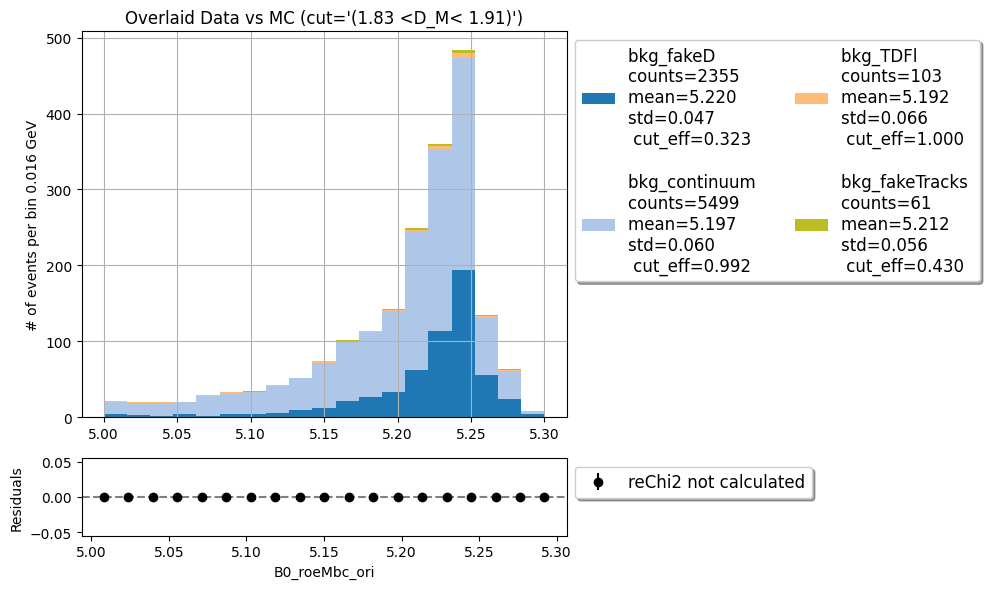

In [23]:
# lgb_tight, D sidebands
b1 = np.linspace(5,5.3,20)
a,b=mpl_mc.plot_data_mc_stacked(variable='B0_roeMbc_ori',bins=b1,figsize=(10,6),
                          cut='(1.83 <D_M< 1.91)',weights={'all_mc':0.25},
                          correction=False,mask=[],ratio=False)

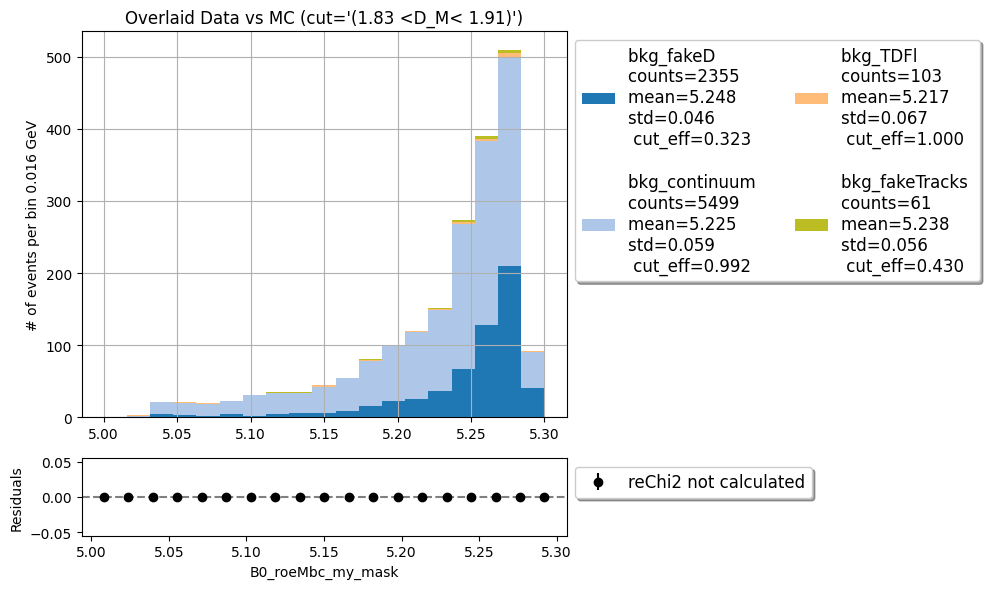

In [26]:
# lgb_tight, D sidebands
b1 = np.linspace(5,5.3,20)
a,b=mpl_mc.plot_data_mc_stacked(variable='B0_roeMbc_my_mask',bins=b1,figsize=(10,6),
                          cut='(1.83 <D_M< 1.91)',weights={'all_mc':0.25},
                          correction=False,mask=[],ratio=False)

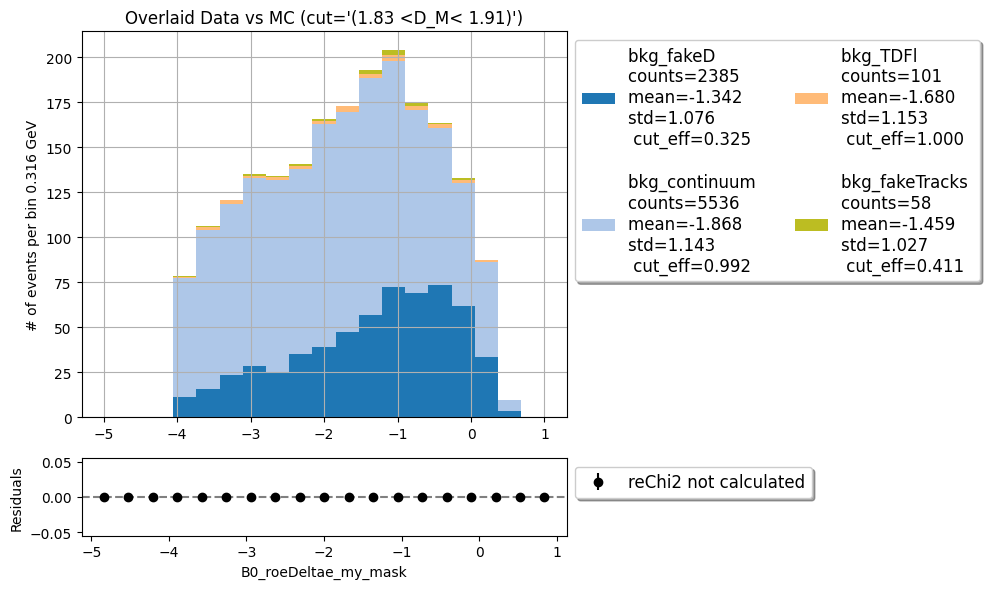

In [15]:
# lgb_tight, D sidebands
b1 = np.linspace(-5,1,20)
a,b=mpl_mc.plot_data_mc_stacked(variable='B0_roeDeltae_my_mask',bins=b1,figsize=(10,6),
                          cut='(1.83 <D_M< 1.91)',weights={'all_mc':0.25},
                          correction=False,mask=[],ratio=False)

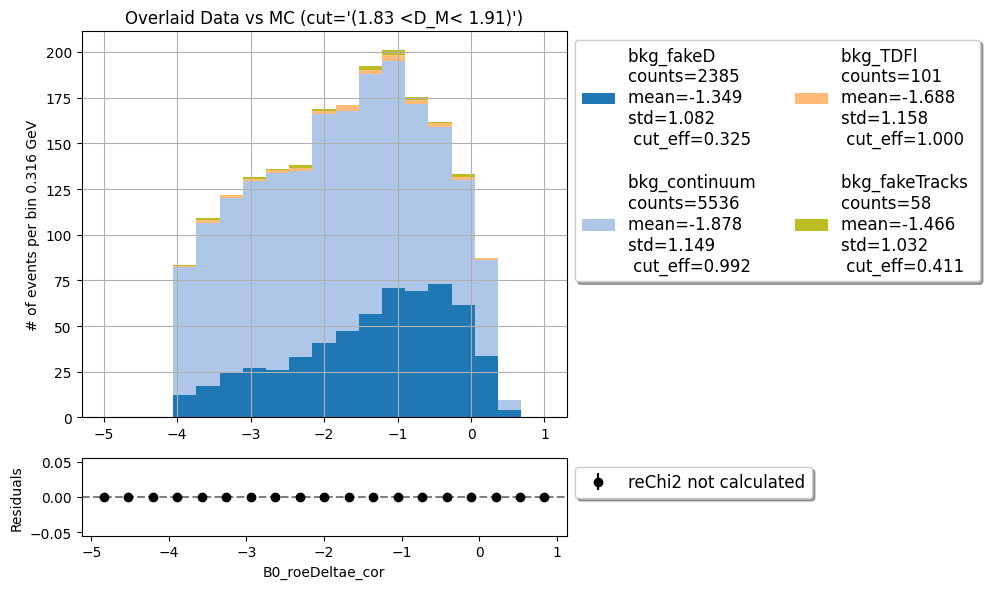

In [26]:
# lgb_tight, D sidebands
b1 = np.linspace(-5,1,20)
a,b=mpl_mc.plot_data_mc_stacked(variable='B0_roeDeltae_cor',bins=b1,figsize=(10,6),
                          cut='(1.83 <D_M< 1.91)',weights={'all_mc':0.25},
                          correction=False,mask=[],ratio=False)

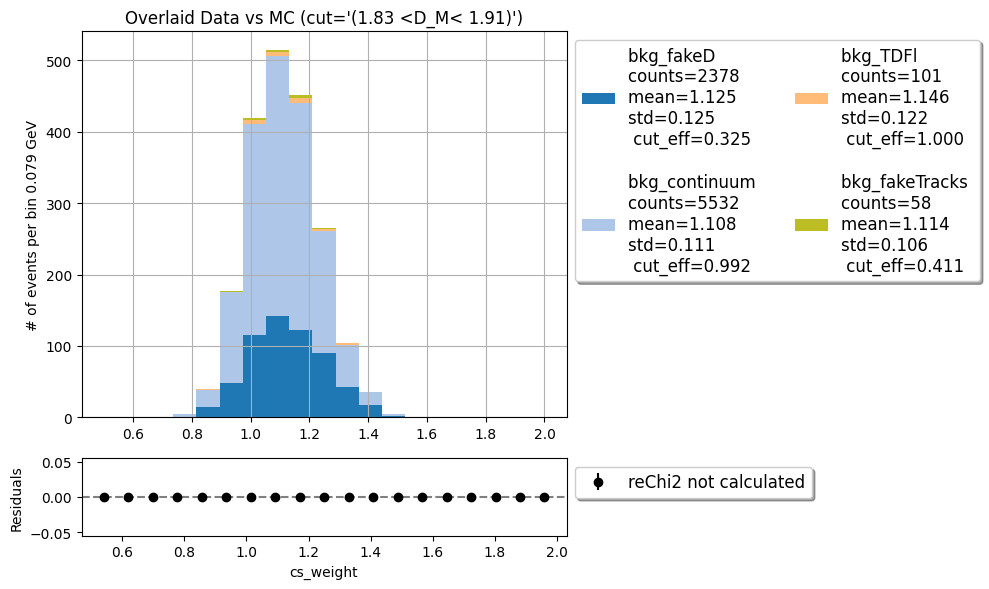

In [44]:
# lgb_tight, D sidebands, binary BDT v2
b1 = np.linspace(0.5,2,20)
a,b=mpl_mc.plot_data_mc_stacked(variable='cs_weight',bins=b1,figsize=(10,6),
                          cut='(1.83 <D_M< 1.91)',weights={'all_mc':0.25},
                          correction=False,mask=[],ratio=False)

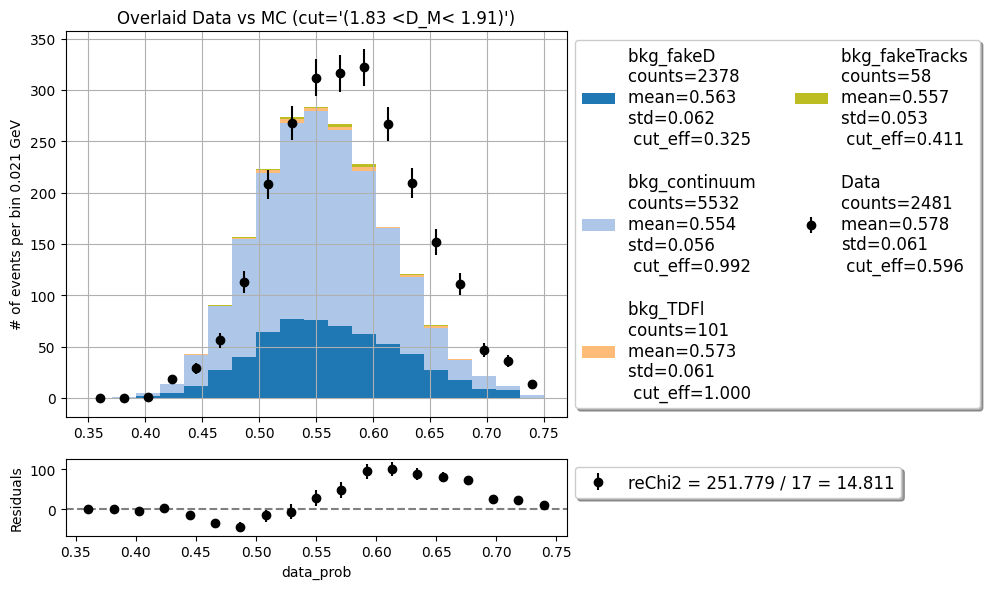

In [12]:
# lgb_tight, D sidebands, binary BDT v2
b1 = np.linspace(0.35,0.75,20)
a,b=mpl.plot_data_mc_stacked(variable='data_prob',bins=b1,figsize=(10,6),
                          cut='(1.83 <D_M< 1.91)',weights={'all_mc':0.25},
                          correction=False,mask=[],ratio=False)

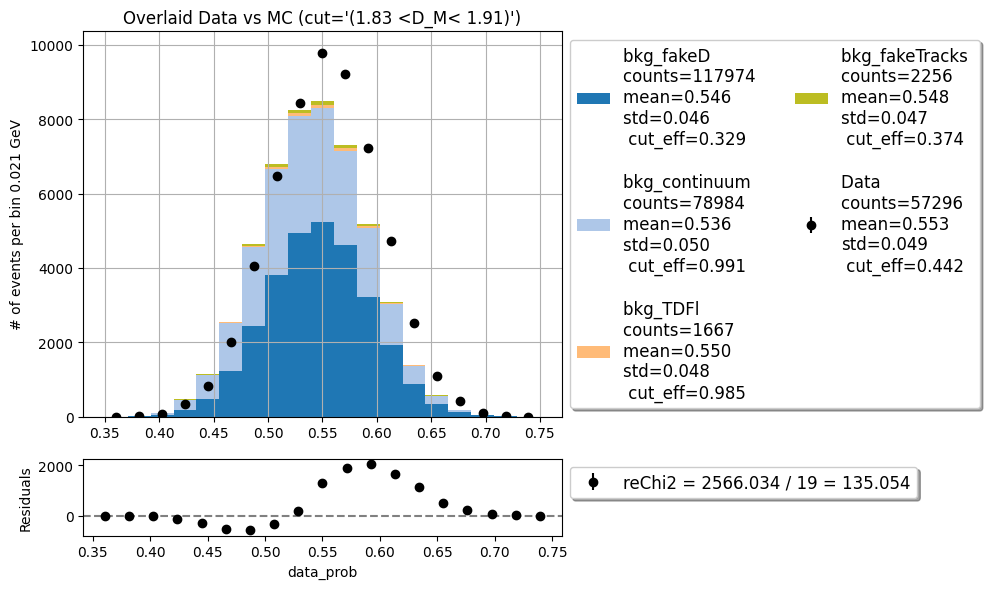

In [13]:
# lgb_tight, D sidebands, binary BDT v1
b1 = np.linspace(0.35,0.75,20)
a,b=mpl.plot_data_mc_stacked(variable='data_prob',bins=b1,figsize=(10,6),
                          cut='(1.83 <D_M< 1.91)',weights={'all_mc':0.25},
                          correction=False,mask=[],ratio=False)

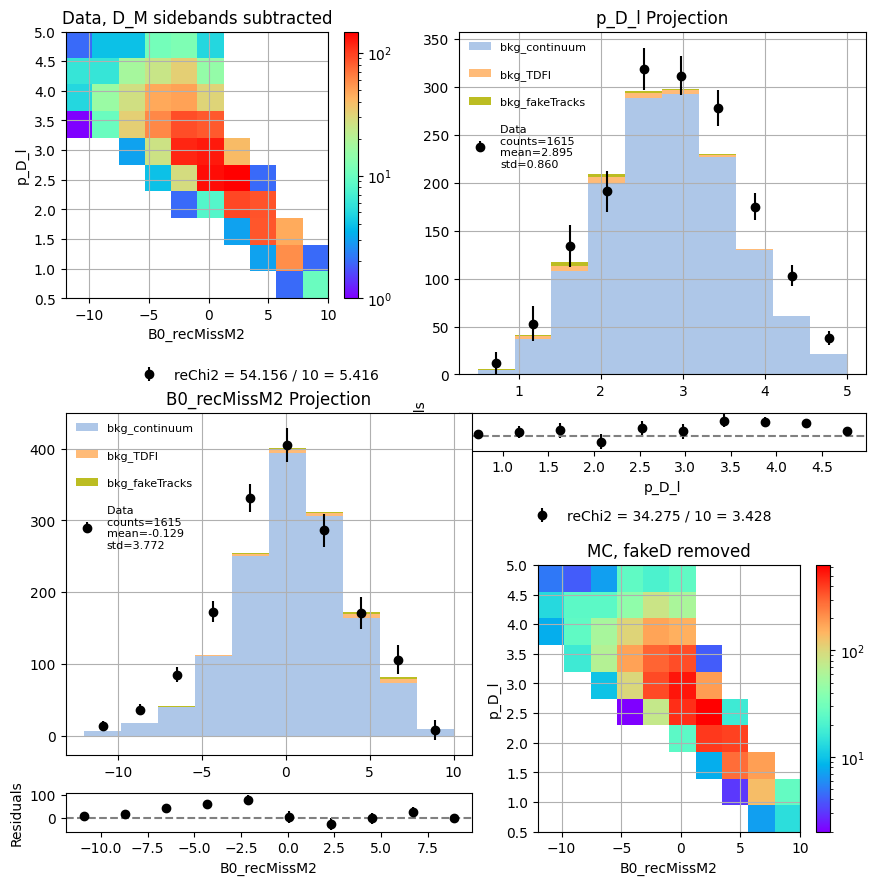

In [48]:
# e channel, lgb_loose, regular MC, no continuum correction
b_mm2 = np.linspace(-12,10,11)
b_pDl = np.linspace(0.5,5,11)

scale = {'data left sideband': 886/906/2,
         'data signal region': 1,
         'data right sideband': 886/866/2,
         'all_mc': 0.25,}
         # 'bkg_continuum': ['cs_weight',0.25]}
par_dict={'var_list':['B0_recMissM2','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'ell_p>0', #'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'weights': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
indices_threshold, temp_data = mpl.plot_data_subtracted_and_mc(**par_dict)

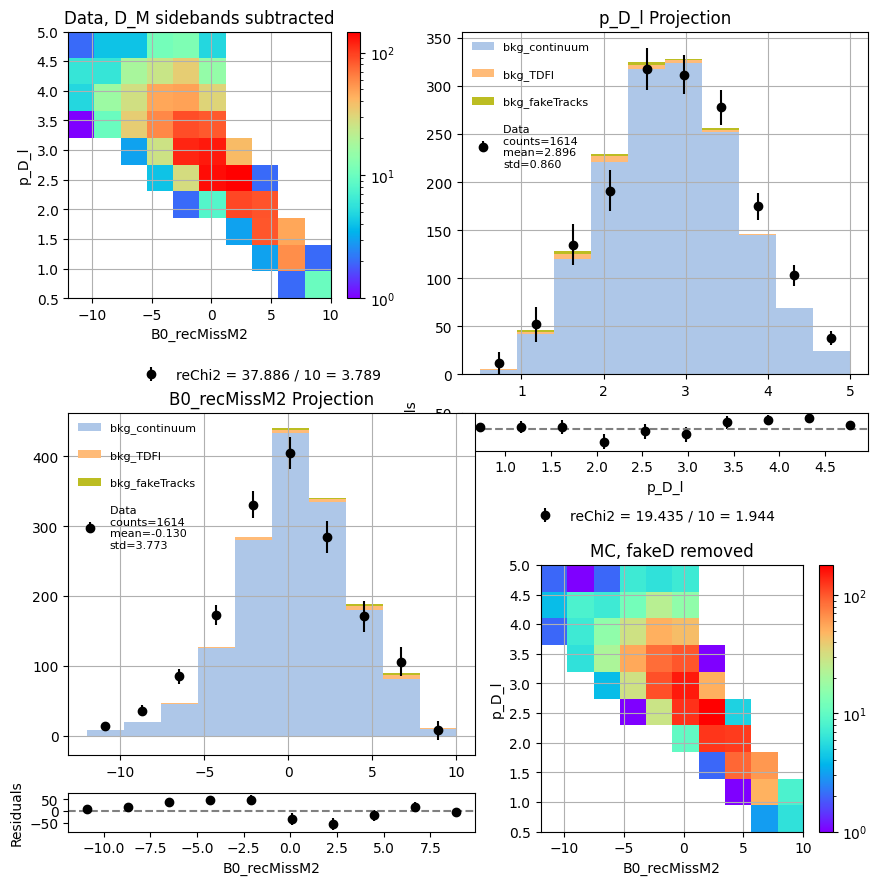

In [57]:
# e channel, lgb_loose, BDT_v1
b_mm2 = np.linspace(-12,10,11)
b_pDl = np.linspace(0.5,5,11)

scale = {'data left sideband': 842/871/2,
         'data signal region': 1,
         'data right sideband': 842/813/2,
         'all_mc': 0.25,
         'bkg_continuum': ['cs_weight',0.25]}
par_dict={'var_list':['B0_recMissM2','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'ell_p>0', #'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'weights': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
indices_threshold, temp_data = mpl.plot_data_subtracted_and_mc(**par_dict)

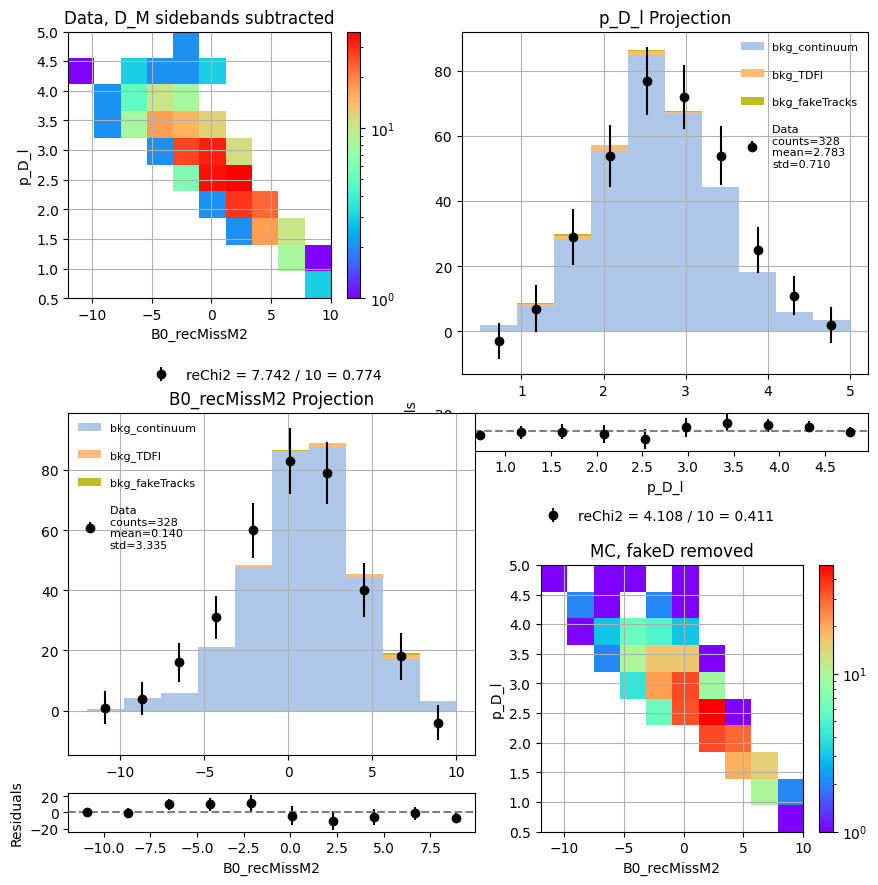

In [58]:
# e channel, lgb_loose, BDT_v1
b_mm2 = np.linspace(-12,10,11)
b_pDl = np.linspace(0.5,5,11)

scale = {'data left sideband': 842/871/2,
         'data signal region': 1,
         'data right sideband': 842/813/2,
         'all_mc': 0.25,
         'bkg_continuum': ['cs_weight',0.25]}
par_dict={'var_list':['B0_recMissM2','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': lgb_tight, #'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'weights': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
indices_threshold, temp_data = mpl.plot_data_subtracted_and_mc(**par_dict)

In [10]:
# lgb + BCS
# df_mc_4S_lgb = util.apply_mva_bcs(df_mc_4S, training_variables, lgb_trueD,library='lgbm')
df_mc_4Soffres_lgb = util.apply_mva_bcs(df_mc_4Soffres, training_variables, lgb_loose,model='multiclass',library='lgbm')
df_data_4Soffres_lgb = util.apply_mva_bcs(df_data_4Soffres, training_variables, lgb_loose,model='multiclass',library='lgbm')

In [11]:
samples_4Soff=util.classify_mc_dict(df_mc_4Soffres_lgb, 'e', template=False)
mpl=util.mpl(samples_4Soff,df_data_4Soffres_lgb)
for name, df in samples_4Soff.items():
    print(name, len(df))

bkg_fakeD 7759
bkg_TDFl 101
bkg_fakeTracks 136
bkg_continuum 5340
bkg_combinatorial 0
bkg_singleBbkg 0
bkg_other_TDTl 0
$D\tau\nu$ 0
$D^\ast\tau\nu$ 0
$D\ell\nu$ 0
$D^\ast\ell\nu$ 0
$D^{\ast\ast}\tau\nu$ 0
$D^{\ast\ast}\ell\nu$_narrow 0
$D^{\ast\ast}\ell\nu$_broad 0
$D\ell\nu$_gap_pi 0
$D\ell\nu$_gap_eta 0
bkg_other_signal 0


# Check 4S vs. 4S_offres

In [ ]:
# compare control vs signal regions MC
b1 = np.linspace(-5,10,50)
scale = {'control region': 1,
         'signal region': 50/200}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_continuum',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

In [ ]:
# compare control vs signal regions MC
b1 = np.linspace(4.8,5.3,50)
scale = {'control region': 1,
         'signal region': 50/200}
mpl.plot_mc_sig_control(variable='B0_roeMbc_my_mask',bins=b1,
                        bkg_name='bkg_continuum',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

In [ ]:
# compare control vs signal regions MC
b1 = np.linspace(4.8,5.3,50)
scale = {'control region': 1,
         'signal region': 50/200}
mpl.plot_mc_sig_control(variable='roeMbc_cor',bins=b1,
                        bkg_name='bkg_continuum',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

In [ ]:
# compare control vs signal regions MC
b1 = np.linspace(-10,10,20)
scale = {'control region': 1,
         'signal region': 50/200}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_continuum',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

In [ ]:
b2 = np.linspace(0.5,5,20)
scale = {'control region': 1,
         'signal region': 50/200}
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,
                        bkg_name='bkg_continuum',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

In [ ]:
b2 = np.linspace(0.2,3.5,20)
scale = {'control region': 1,
         'signal region': 50/200}
mpl.plot_mc_sig_control(variable='D_CMS_p',bins=b2,
                        bkg_name='bkg_continuum',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

In [ ]:
b2 = np.linspace(0.2,2.5,20)
scale = {'control region': 1,
         'signal region': 50/200}
mpl.plot_mc_sig_control(variable='ell_CMS_p',bins=b2,
                        bkg_name='bkg_continuum',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

# Check Data vs. MC

# Create data driven template for continuum
## 1. Calculate the sidebands to sig region scaling factors
### a. Histogram the D_M distribution

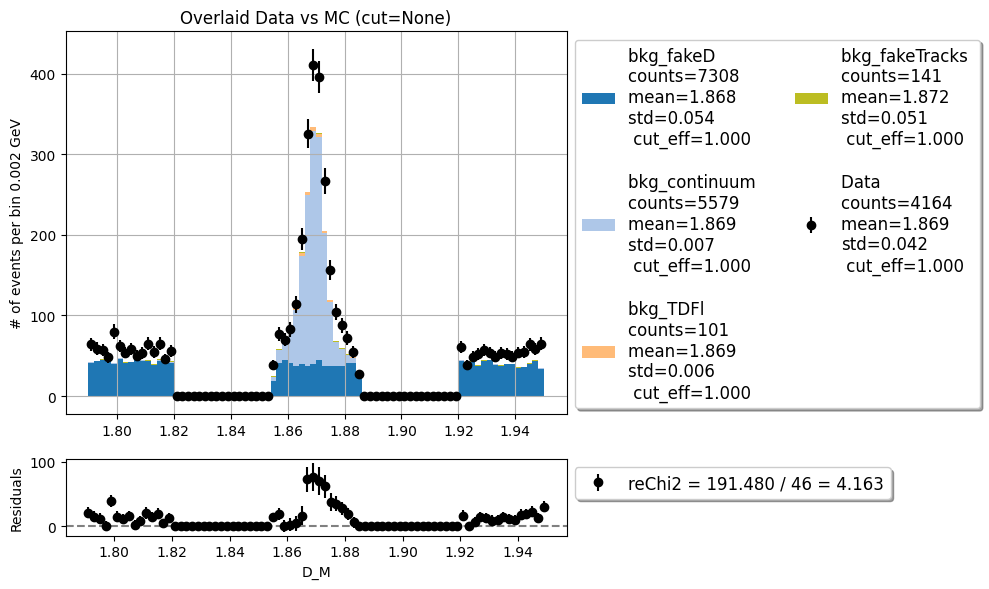

In [15]:
# BDT signal region
b1 = np.linspace(1.79,1.95,81)
weights={'all_mc':0.25}
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(variable='D_M',bins=b1,cut=None,
                                                      weights=weights,correction=False,
                                                      mask=[],figsize=(10,6),ratio=False)

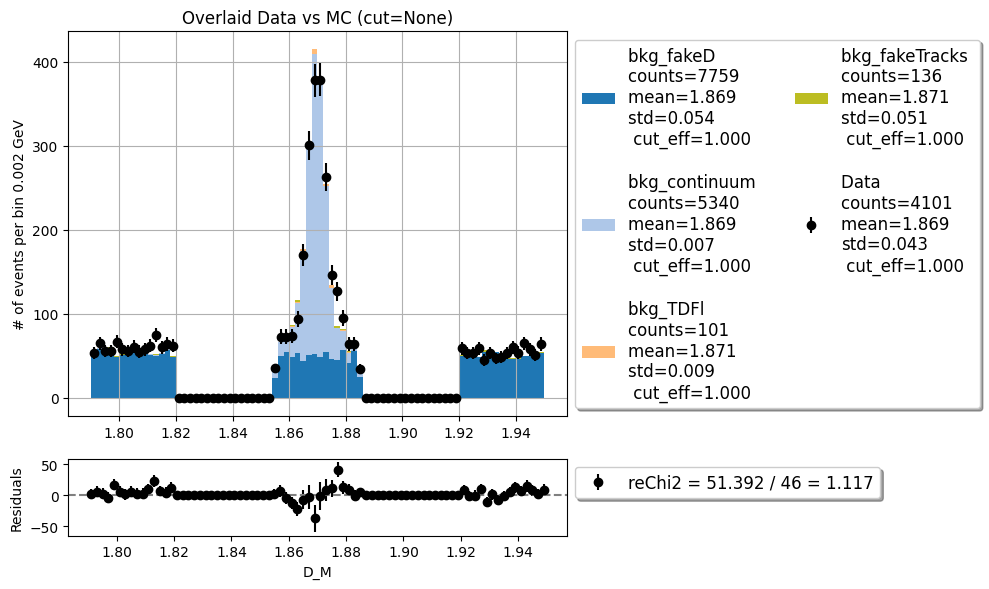

In [12]:
# BDT signal region
b1 = np.linspace(1.79,1.95,81)
weights={'all_mc':0.25*1.184}
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(variable='D_M',bins=b1,cut=None,
                                                      weights=weights,correction=False,
                                                      mask=[],figsize=(10,6),ratio=False)

### b. fit the FakeD with a polynomial

In [16]:
fitter = util.fit_Dmass(x_edges=b1, hist=data_hist_all, poly_only=True)

In [46]:
m_ls, c_ls, result_ls = fitter.fit_gauss_poly_LS(deg=1, loss='linear') #'soft_l1'
m_ls
# fitter.plot_poly(x=bin_edges_sb, y=data_hist_sb, yerr=data_err_sb,result=result)

initial parameters= [ 6.50e+00  1.87e+00  4.00e-02 -2.71e+01  9.29e+01]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.89 (χ²/ndof = 0.6)      │              Nfcn = 40               │
│ EDM = 1.1e-13 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.00    │   0.07    │            │            │    0    │         │  yes  │
│ 1 │ x1   │   1.870   │   0.019   │            │            │    0    │         │  yes  │
│ 2 │ x2   │  40.0e-3  │  0.4e-3   │            │            │    0    │         │  yes  │
│ 3 │ x3   │    -29    │    10     │            │            │         │         │       │
│ 4 │ x4   │    96     │    19     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────────────────────┐
│    │   x0   x1   x2   x3   x4 │
├────┼──────────────────────────┤
│ x0 │    0    0    0    0    0 │
│ x1 │    0    0    0    0    0 │
│ x2 │    0    0    0    0    0 │
│ x3 │    0    0    0 98.1 -180 │
│ x4 │    0    0    0 -180  345 │
└────┴──────────────────────────┘

In [17]:
m_ml, c_ml, result_ml = fitter.fit_gauss_poly_ML(deg=1)
m_ml
# fitter.plot_poly(x=bin_edges_sb, y=data_hist_sb, yerr=data_err_sb,result=result)

initial parameters= [ 8.300e+00  1.870e+00  4.000e-02  4.164e+03 -2.950e+01  1.113e+02]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 28.2 (χ²/ndof = 1.1)       │              Nfcn = 67               │
│ EDM = 1.18e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.00    │   0.08    │            │            │    0    │         │  yes  │
│ 1 │ x1   │   1.870   │   0.019   │            │            │    0    │         │  yes  │
│ 2 │ x2   │  40.0e-3  │  0.4e-3   │            │            │    0    │         │  yes  │
│ 3 │ x3   │  4.49e3   │  0.11e3   │            │            │         │         │       │
│ 4 │ x4   │    -30    │    70     │            │            │         │         │       │
│ 5 │ x5   │  0.10e3   │  0.28e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────┐
│    │       x0       x1       x2       x3       x4       x5 │
├────┼───────────────────────────────────────────────────────┤
│ x0 │        0        0        0        0      0e3        0 │
│ x1 │        0        0        0        0      0e3        0 │
│ x2 │        0        0        0        0      0e3        0 │
│ x3 │        0        0        0 1.24e+04     -0e3       -0 │
│ x4 │      0e3      0e3      0e3     -0e3 5.57e+03    -21e3 │
│ x5 │        0        0        0       -0    -21e3 7.87e+04 │
└────┴───────────────────────────────────────────────────────┘

### c. Calculate the yield ratio

In [ ]:
area_left,error_left = fitter.poly_integral(xrange=[1.79,1.82],result=result_ls)
area_sig, error_sig = fitter.poly_integral(xrange=[1.855,1.885],result=result_ls)
area_right,error_right = fitter.poly_integral(xrange=[1.92,1.95],result=result_ls)

In [18]:
yields_left = fitter.poly_integral(xrange=[1.79,1.82],result=result_ml)
yields_sig = fitter.poly_integral(xrange=[1.855,1.885],result=result_ml)
yields_right = fitter.poly_integral(xrange=[1.92,1.95],result=result_ml)

Yields from 1.79 to 1.82 = 871.376 ± 30.151
Yields from 1.855 to 1.885 = 842.350 ± 20.891
Yields from 1.92 to 1.95 = 813.325 ± 28.349


In [50]:
print('left sideband',len(samples_4Soff['bkg_fakeD'].query('1.79<D_M<1.82'))*0.25)
print('sig region',len(samples_4Soff['bkg_fakeD'].query('1.855<D_M<1.885'))*0.25)
print('right sideband',len(samples_4Soff['bkg_fakeD'].query('1.92<D_M<1.95'))*0.25)

left sideband 641.25
sig region 588.75
right sideband 595.0


In [19]:
print('left sideband',(len(samples_4Soff['bkg_fakeD'].query('1.79<D_M<1.82'))+len(samples_4Soff['bkg_fakeTracks'].query('1.79<D_M<1.82')))*0.25)
print('sig region',(len(samples_4Soff['bkg_fakeD'].query('1.855<D_M<1.885'))+len(samples_4Soff['bkg_fakeTracks'].query('1.855<D_M<1.885')))*0.25)
print('right sideband',(len(samples_4Soff['bkg_fakeD'].query('1.92<D_M<1.95'))+len(samples_4Soff['bkg_fakeTracks'].query('1.92<D_M<1.95')))*0.25)

left sideband 650.75
sig region 609.0
right sideband 602.5


In [31]:
print(636/664, 588/641, 611/653)
print(636/608, 588/595, 610/605)

0.9578313253012049 0.9173166926677067 0.9356814701378254
1.0460526315789473 0.9882352941176471 1.0082644628099173


In [28]:
a = len(df_data_4Soffres_lgb.query('1.79<D_M<1.82'))
b = len(df_data_4Soffres_lgb.query('1.92<D_M<1.95'))
print('data',a,b, a/b)

truth 922 865 1.0658959537572255


### d. Plot and compare MC of the weighted sideband and signal region

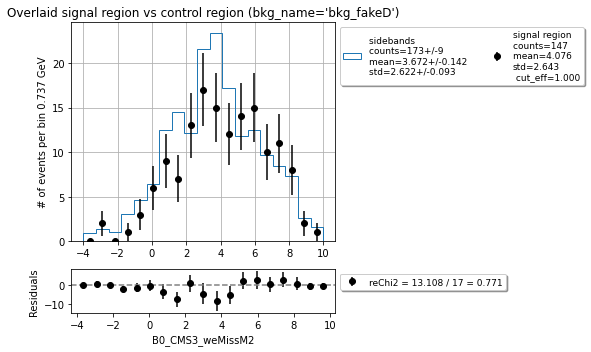

In [25]:
# showing the scaled sidebands vs. sig region from mc
b1 = np.linspace(-4,10,20)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_fakeD',cut=None,merge_sidebands=True,
                        scale=scale,correction=False,mask=[],legend_fs=9)

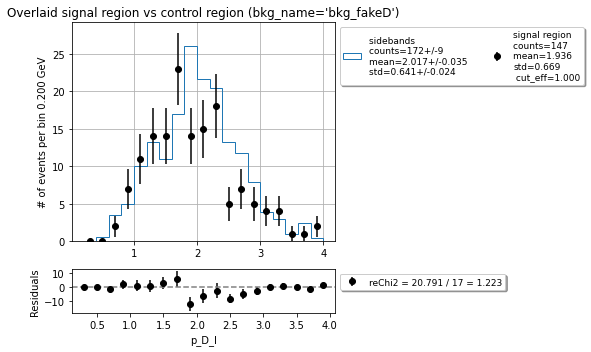

In [26]:
b2 = np.linspace(0.2,4,20)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,merge_sidebands=True,
                        bkg_name='bkg_fakeD',cut=None,
                        scale=scale,correction=False,mask=[],legend_fs=9)

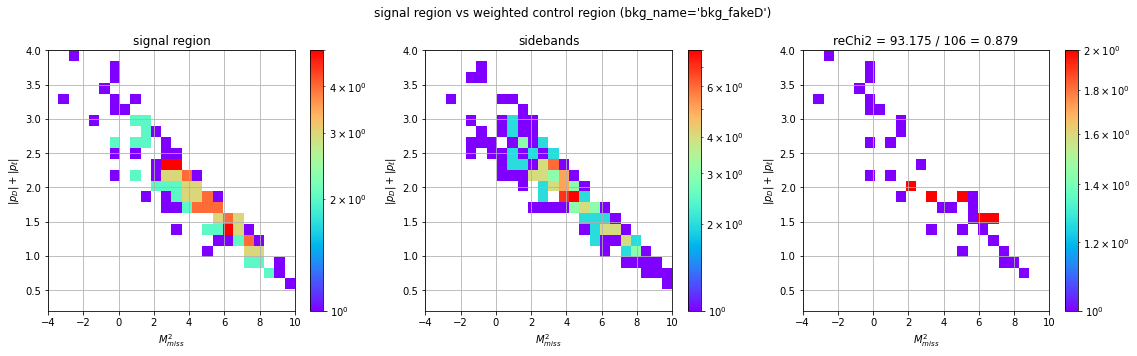

In [50]:
b1 = np.linspace(-4,10,25)
b2 = np.linspace(0.2,4,25)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable=['B0_CMS3_weMissM2','p_D_l'],
                        bins=[b1,b2],
                        bkg_name='bkg_fakeD',cut=None,merge_sidebands=True,
                        scale=scale,correction=True,mask=[],figsize=(16,5))

## 2. Subtract the FakeD in the signal region

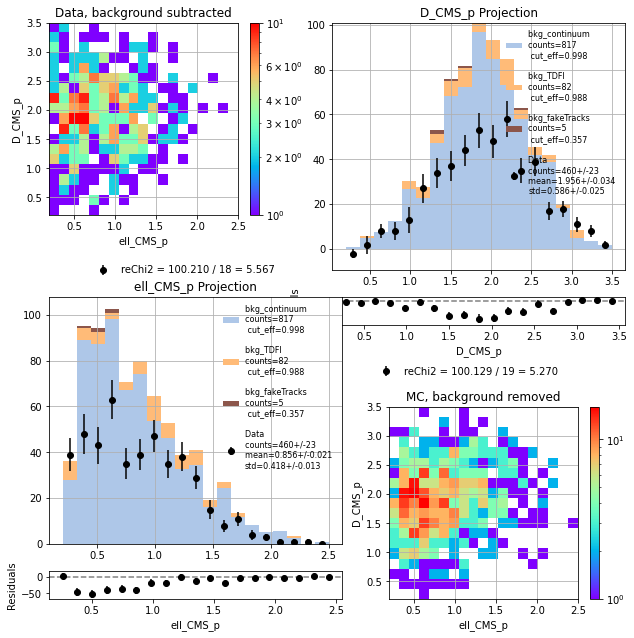

In [39]:
# BDT signal, pl; pd
b_mm2 = np.linspace(0.2,2.5,21)
b_pDl = np.linspace(0.2,3.5,21)
scale = {'data left sideband': yields_sig/yields_left/2,
         'data signal region': 1,
         'data right sideband': yields_sig/yields_right/2,
         'mc signal region': 42/50}
par_dict={'var_list':['ell_CMS_p','D_CMS_p'],
          'bin_list': [b_mm2, b_pDl],
          'cut': None,
          'scale': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
mpl.plot_data_subtracted_and_mc(**par_dict)

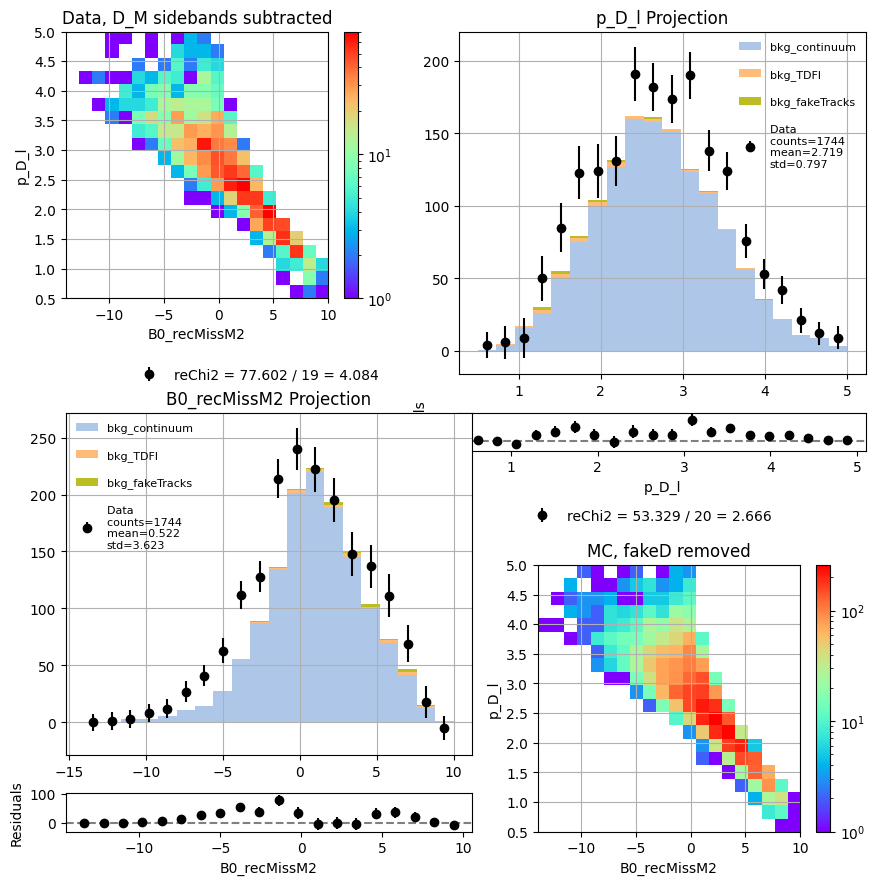

In [29]:
# e channel, lgb_loose
b_mm2 = np.linspace(-14,10,21)
b_pDl = np.linspace(0.5,5,21)

scale = {'data left sideband': 886/906/2,
         'data signal region': 1,
         'data right sideband': 886/866/2,
         'all_mc': 0.25}
par_dict={'var_list':['B0_recMissM2','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'ell_p>0', #'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'weights': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
indices_threshold, temp_data = mpl.plot_data_subtracted_and_mc(**par_dict)

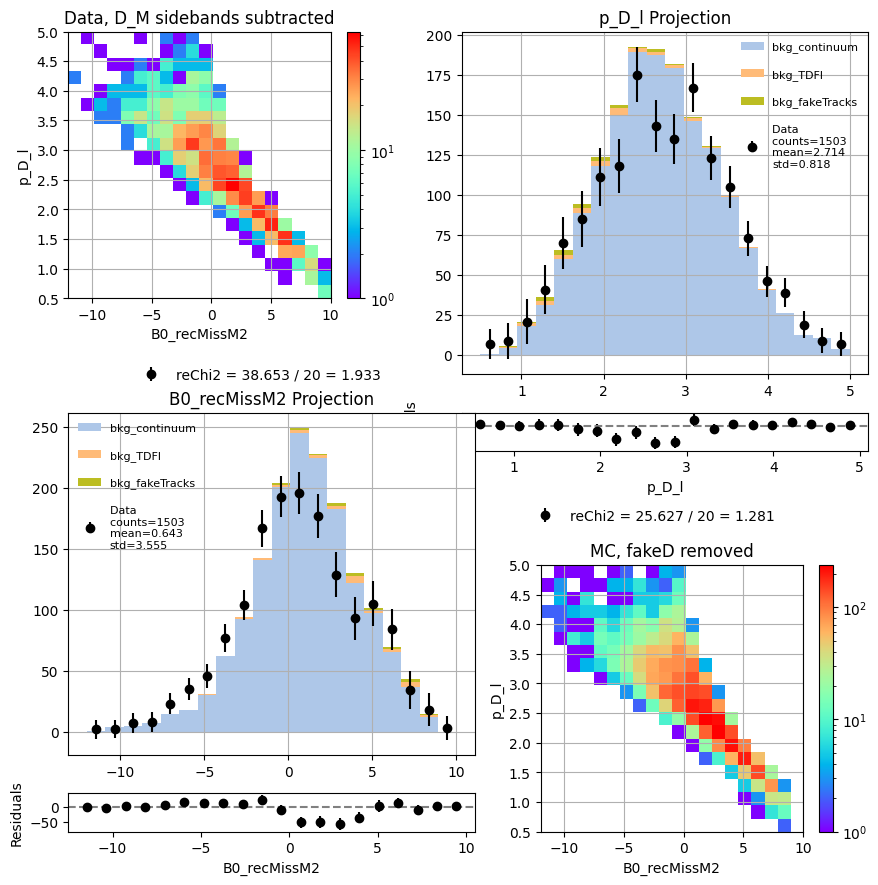

In [13]:
# e channel, lgb_loose
b_mm2 = np.linspace(-12,10,21)
b_pDl = np.linspace(0.5,5,21)

scale = {'data left sideband': 886/906/2,
         'data signal region': 1,
         'data right sideband': 886/866/2,
         'all_mc': 0.25*1.184}
par_dict={'var_list':['B0_recMissM2','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'ell_p>0', #'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'weights': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
indices_threshold, temp_data = mpl.plot_data_subtracted_and_mc(**par_dict)

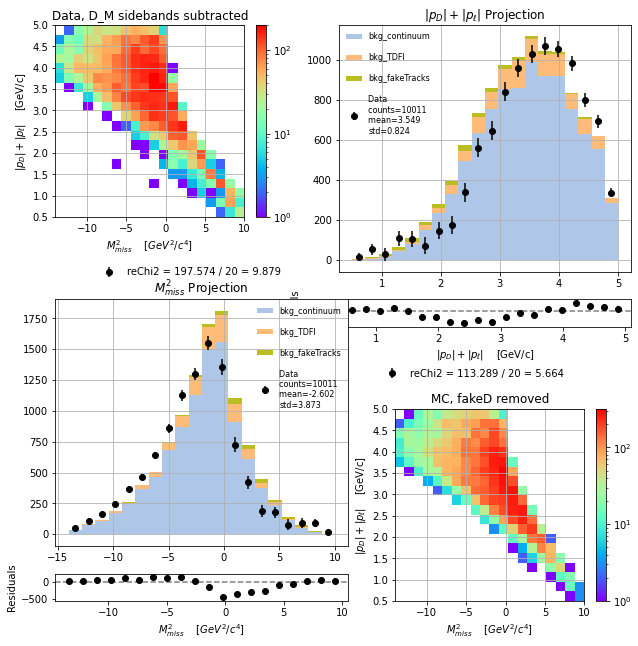

In [13]:
# e channel, lgb_loose
b_mm2 = np.linspace(-14,10,21)
b_pDl = np.linspace(0.5,5,21)
scale = {'data left sideband': 0.5,
         'data signal region': 1,
         'data right sideband': 0.5,
         'all_mc': 0.25}
par_dict={'var_list':['B0_recMissM2','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'ell_p>0', #'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'weights': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
indices_threshold, temp_data = mpl.plot_data_subtracted_and_mc(**par_dict)

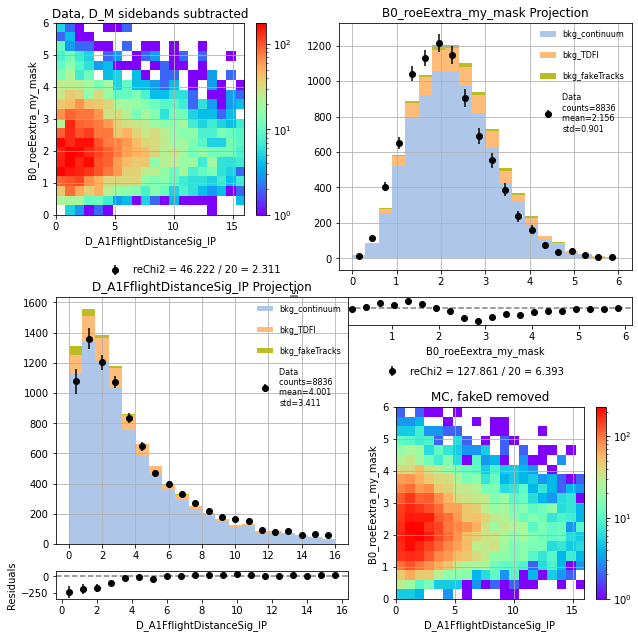

In [14]:
# e channel, lgb_trueD
b_mm2 = np.linspace(0,16,21)
b_pDl = np.linspace(0,6,21)

par_dict={'var_list':['D_A1FflightDistanceSig_IP','B0_roeEextra_my_mask'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'ell_p>0', #'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'weights': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
indices_threshold, temp_data = mpl.plot_data_subtracted_and_mc(**par_dict)

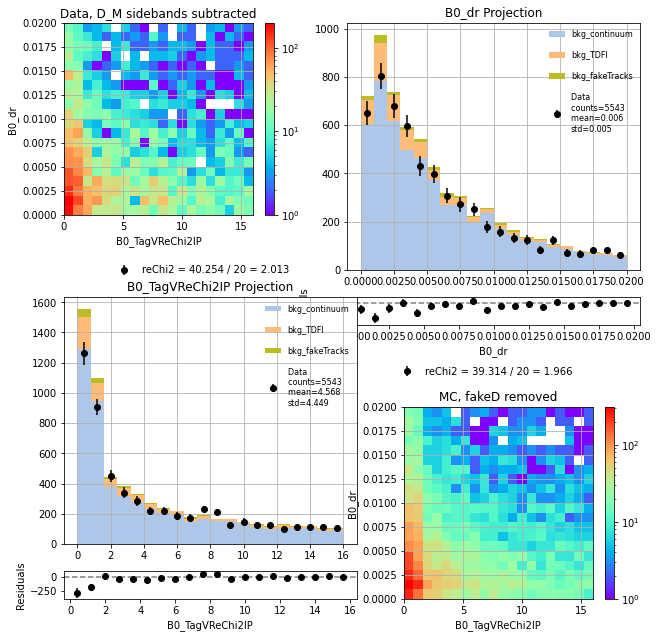

In [16]:
# e channel, lgb_trueD
b_mm2 = np.linspace(0,16,21)
b_pDl = np.linspace(0,0.02,21)

par_dict={'var_list':['B0_TagVReChi2IP','B0_dr'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'ell_p>0', #'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'weights': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
indices_threshold, temp_data = mpl.plot_data_subtracted_and_mc(**par_dict)

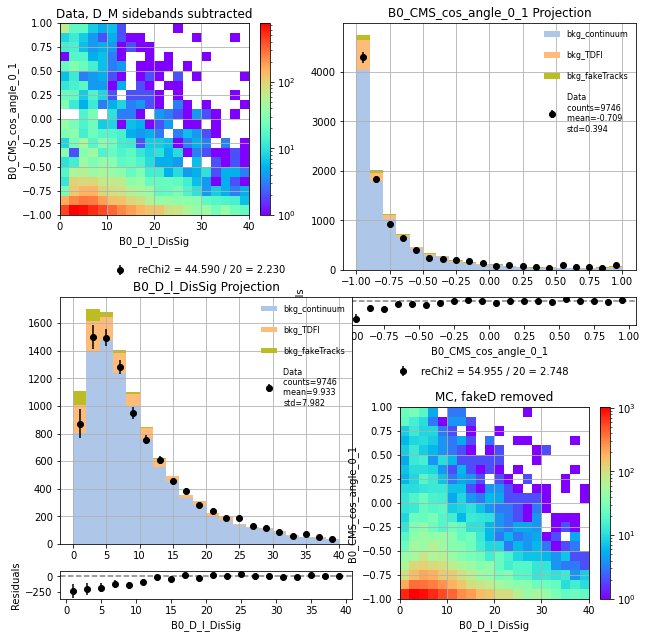

In [17]:
# e channel, lgb_trueD
b_mm2 = np.linspace(0,40,21)
b_pDl = np.linspace(-1,1,21)

par_dict={'var_list':['B0_D_l_DisSig','B0_CMS_cos_angle_0_1'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'ell_p>0', #'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'weights': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
indices_threshold, temp_data = mpl.plot_data_subtracted_and_mc(**par_dict)

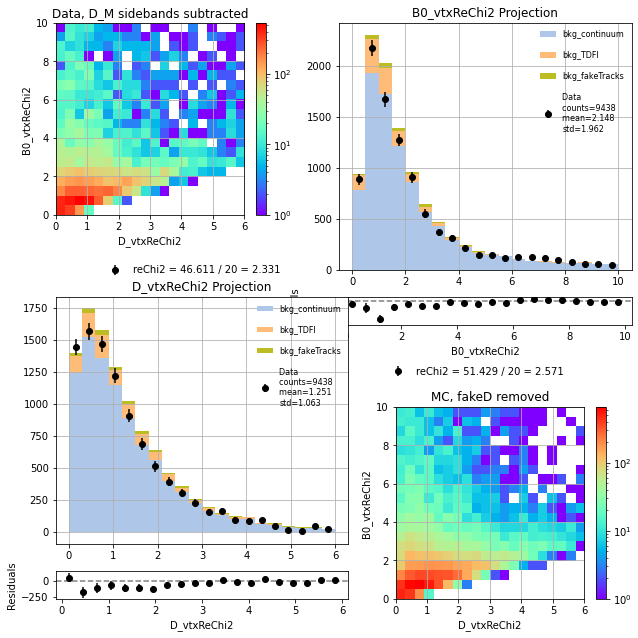

In [18]:
# e channel, lgb_trueD
b_mm2 = np.linspace(0,6,21)
b_pDl = np.linspace(0,10,21)

par_dict={'var_list':['D_vtxReChi2','B0_vtxReChi2'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'ell_p>0', #'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'weights': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
indices_threshold, temp_data = mpl.plot_data_subtracted_and_mc(**par_dict)

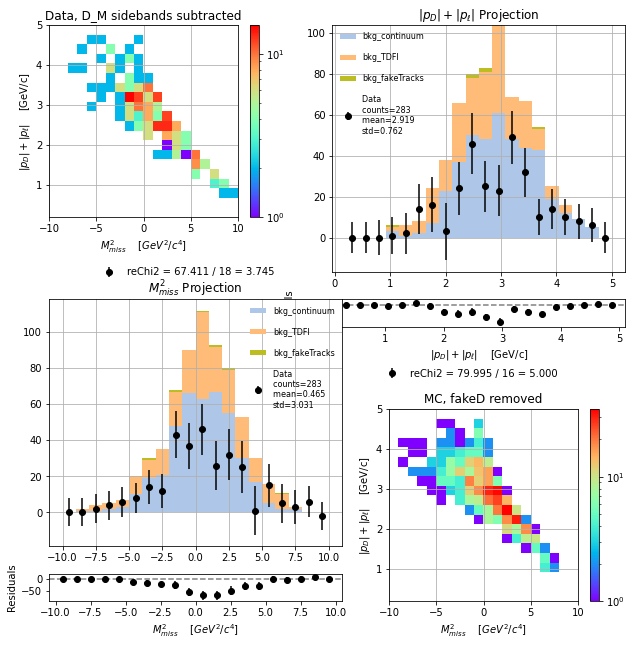

In [32]:
# mu channel
b_mm2 = np.linspace(-10,10,21)
b_pDl = np.linspace(0.2,5,21)
scale = {'data left sideband': 75/64/2 * 50/24,
         'data right sideband': 75/86/2 * 50/24,
         'data signal region': 50/24}

par_dict={'var_list':['B0_CMS3_weMissM2','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'ell_p>0', #'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'weights': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
indices_threshold, temp_data = mpl.plot_data_subtracted_and_mc(**par_dict)